# Logistic Regression Tutorial

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
import random

## Classification

In regression we were trying to predict a continuous value - e.g. exam score.

In classification we predict a class label for a given data point - e.g. pass/fail the exam. It might be a two-class problem like this (binary classification) or a many-class problem.

Not only do we predict a class label, we also predict a probability for each class.

Our example of pass fail can be pictured like this

![logistic_regression](https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg)

To perform classification we need to make a **decision**. This requires defining a **decision boundary**. This is going to be an affine set - in 1D (i.e. with one feature) this will be a point; in 2D (with two features) this will be a line; with three features a plane; etc...

In our case above we could say if `num_hours_studying` $\gt 2.7$ then we will predict `pass`.

In a bivariate case our decision boundary might look like this

![bivariate_logistic_regression](https://i0.wp.com/ucanalytics.com/blogs/wp-content/uploads/2017/09/Scatter-Plot-with-Boundary-Logistic-Regression.jpg?resize=768%2C578)

## Hypothesis

Our hypothesis for logistic regression can be linear or non-linear. What is different with linear regression is we want to output class probabilities. We need a way to express our hypothesis as a probability value.

To do this we use the sigmoid function

$$\sigma(h) = \frac{e^h}{e^h + 1} = \frac{1}{1 + e^{-h}}$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

We can see that this function is going to squash its input into the range $(0, 1)$ giving us a valid probability value.

We will pass our linear or non-linear function of the data through the sigmoid function to get our final hypothesis

$$h_\theta(\mathbf{x}) = P(y=1|\mathbf{x}) = \sigma(\mathbf{a}^\top\mathbf{x})$$

We can arbitrarily decide what $y=1$ means - in the example let's say passes the exam. Then the probability of failing the exam is given by

$$P(y=0|\mathbf{x}) = 1 - P(y=1|\mathbf{x}) = 1 - \sigma(\mathbf{a}^\top\mathbf{x})$$

## Loss Function

MSE is not an appropriate loss function here. We are dealing with probabilities so the natural choice is negative log loss

$$\text{NLL} = -y \log(h_\theta) - (1 - y)\log(1 - h_\theta))$$

$y$ is going to be either $1$ or $0$ so only one of these two terms will apply.

## Optimization

We cannot use a closed form here so we will have to use **gradient descent**.

When we learned about linear regression we noted that the loss surface was convex - from any point you know how to reach the global minimum.

Our loss here is highly non-convex. Instead we need to use an iterative algorithm to take clever steps from an initial starting point to try and find a good local minimum. The picture looks like this

![gradient_descent](https://cdn-images-1.medium.com/max/1600/1*f9a162GhpMbiTVTAua_lLQ.png)

The key idea is that if you take the gradient of the parameters with respect to the loss at a particular point, it will tell you how to change those parameters to reduce the loss

![gradient_descent_2](https://cdn-images-1.medium.com/max/800/0*rBQI7uBhBKE8KT-X.png)

Clearly in this diagram if we start on the right, we need to **decrease** $w$ in order to lower our loss. That's really the main idea.

With this algorithm we make a number of "steps" to update an improve the parameters. Each step the update is

$$\theta' = \theta - \beta \frac{\partial \text{NLL}(h_\theta, y)}{\partial \theta}$$

Here the hyperparameter $\beta$ is very important - it controls how big our steps are. In the above diagram if the learning rate made us step half the width of the "U" we would just bounce from side to side and never settle in the optimum.

We also need to pay attention to how many steps we take. In the diagram if we just took two we wouldn't give the algorithm time to settle. In practice we will take many more steps than two. Be aware that you will have to tune this hyperparameter.

## Dataset

A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of coronary heart disease (CHD). Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in  Rousseauw et al, 1983, South African Medical Journal.  Downloaded from https://web.stanford.edu/~hastie/ElemStatLearn/.

Features:
- sbp: systolic blood pressure
- tobacco:	cumulative tobacco (kg)
- ldl: low densiity lipoprotein cholesterol
- adiposity
- famhist: family history of heart disease (Present, Absent)
- typea: type-A behavior
- obesity
- alcohol: current alcohol consumption
- age: age at onset
- chd: response, coronary heart disease

## Preprocess the Data

### Load the Data

As usual, load the data with `pd.read_csv`. We have an index column in position zero and the separator is a comma. Load the data into a variable named `data`.

In [86]:
"""
Task: load the data into a variable named data
"""
file_name = 'SAheart.data'
data = pd.read_csv(file_name, sep=',', index_col=0)

In [87]:
assert len(data) == 462
assert len(data.columns) == 10
print('Success!')

Success!


In [65]:
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### Manage Categorial Variable

We once again have a categorical variable, `famhist`, which we need to make into a one-hot encoding. We do this for you this time.

In [88]:
data['famhist_true'] = data['famhist'] == 'Present'
data['famhist_false'] = data['famhist'] == 'Absent'
data = data.drop(['famhist'], axis=1)

Because we will perform feature selection later, this time let's take the time to make a convenient function to separate a dataset into `train` and `test` and also split $x$ and $y$ in boths sets for us. We do this for you.

In [133]:
def splits(data):
    # control randomization for reproducibility
    np.random.seed(42)
    random.seed(42)
    train, test = model_selection.train_test_split(data)
    x_train = train.loc[:, train.columns != 'chd']
    y_train = train['chd']
    x_test = test.loc[:, test.columns != 'chd']
    y_test = test['chd']
    return x_train, y_train, x_test, y_test

## Data Visualization

Let's now take a look at the relationships in the data. We can still use scatterplots for classification, but they look a bit different. Again let's make a convenient function for later use. As you will see we stretch the plot size to try and make these plots a bit clearer.

In [146]:
def plot_feature(_data, feature_name):
    plt.figure(figsize=(10, 3))
    plt.scatter(_data[feature_name], _data['chd'])
    plt.xlabel(feature_name)
    plt.ylabel('response')
    plt.show()

We'll take a look at one feature together then you should explore the rest of the dataset on your own and form your own opinions about which features are going to be useful.

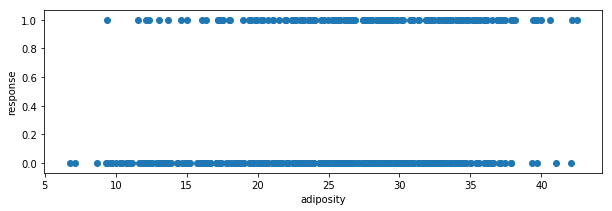

In [147]:
plot_feature(data, 'adiposity')

There seems to be a reasonable correlation here - this might be a useful feature. Explore the rest yourself with our helper function.

In [ ]:
"""
Task: Explore the relationships in the data using the helper function `plot_feature`
"""


## Fit Baseline Model

### Evaluation

Since we are predicting the label of our classes (heart disease or none), we have a much more intuitive measure of performance: prediction accuracy. To calculate this we will use `sklearn.metrics.accuracy_score` - reference here http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html.

In [136]:
def evaluate(model, x_train, y_train, x_test, y_test):
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, train_preds)
    test_acc = metrics.accuracy_score(y_test, test_preds)
    print('Train accuracy: %s' % train_acc)
    print('Test accuracy: %s' % test_acc)

### Gradient Descent Model

Here I will implement a baseline gradient descent model. I will not perform feature selection or tune regularization. You will then need to beat this baseline.

The baseline use the `sklearn.linear_model.SGDClassifier` class - reference here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier. By passing the argument `loss='log'` we get a logistic regression model.

I append `bl` to the variables here to mark them as the baseline. Let's also add one more convenient helper function that will split the data, train the model, and return train and test accuracies.

In [137]:
def split_train_evaluate(model, data):
    x_train, y_train, x_test, y_test = splits(data)
    model.fit(x_train, y_train)
    evaluate(model, x_train, y_train, x_test, y_test)

model_bl = linear_model.SGDClassifier(loss='log', max_iter=10000)
split_train_evaluate(model_bl, data)

Train accuracy: 0.6994219653179191
Test accuracy: 0.6982758620689655


## Beat the Baseline

What may be difficult about this task is that for the first time during our tutorials we have a number of hyperparameters. This is the common situation in machine learning practice. One approach to dealin with this issue is to define a reasonable set of values for each hyperparameter and then search over all combinations of them using cross validation on the training set. This technique is called **grid search**.

### Grid Search

We can perform gid search with `sklearn.model_selection.GridSearchCV`, reference here http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

Let's try it out with a very small search space to show you how it works.

In [138]:
x_train, y_train, x_test, y_test = splits(data)
grid_search = model_selection.GridSearchCV(
    estimator=linear_model.SGDClassifier(),
    param_grid={'alpha': [0.01, 0.1, 1.],
                'max_iter': [1000, 10000]},
    cv=10,
    return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.1, 1.0], 'max_iter': [1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The grid search results come in a dictionary that can be loaded directly into a pandas `DataFrame` for viewing so you can see what the parameter choices did.

In [143]:
r = pd.DataFrame(grid_search.cv_results_)
# we only want a subset of the columns for a precise summary
r[['params', 'mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
0,"{'alpha': 0.01, 'max_iter': 1000}",0.633707,0.630058
1,"{'alpha': 0.01, 'max_iter': 10000}",0.728646,0.699422
2,"{'alpha': 0.1, 'max_iter': 1000}",0.708455,0.696532
3,"{'alpha': 0.1, 'max_iter': 10000}",0.726074,0.722543
4,"{'alpha': 1.0, 'max_iter': 1000}",0.712268,0.690751


The grid seach also picks the best model for you automatically which you can then use with the optimal parameters from the grid search

In [145]:
best_model = grid_search.best_estimator_
evaluate(best_model, x_train, y_train, x_test, y_test)

Train accuracy: 0.7485549132947977
Test accuracy: 0.7241379310344828


So we have already improved our baseline.

### Your Turn

You can use the grid search code above to find your best model and beat our baseline test accuracy of $72.4$ percent.

You will want to examine the parameters in the `SGDClassifier` documentation (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) and make your own decisions about what a reasonable search space should look like.

Also be aware that if your best value for a parameter is on the edge of your search space, you want to expand the space further in that direction to see if you can keep climbing. For example if my space for $\alpha$ was `[0.1, 0.5, 1.]`, and the best result came with `1.`, then I should definitely try `2.` and `5.` and so on.

Also don't forget feature selection. Return to the section where we were visualizing. Try and apply some $L2$ penalty through the parameters to perform ridge regression if you like.

In [ ]:
"""
Task: Beat the baseline 72.4% test accuracy
"""
